# Ablation Study: Merge Score
In this notebook, we compare ClaP with with different merge scores.

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

from aeon.visualisation import plot_critical_difference
from external.MCM import MCM
from wand.image import Image

sns.set_theme()
sns.set_color_codes()

import os
import sys

sys.path.append("../../")

/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Let's choose a score for evaluation (AMI).

In [3]:
eval_score = "ami_score"

Let's load the scores from the different methods.

In [4]:
classifier = ["cgain", "F1", "Log-loss", "AMI", "Hamming-loss", "ROCAUC"]

datasets = ["train"]
methods, dfs = list(), list()

for candidate_name in classifier:
    methods.append((candidate_name, f"{candidate_name}.csv.gz"))

for idx, (name, file_name) in enumerate(methods):
    df = []

    for d in datasets:
        df.append(pd.read_csv(f"../../experiments/ablation_study/{d}_{file_name}",
                              compression="gzip"))

    df = pd.concat(df)
    df.sort_values(by="dataset", inplace=True)
    dfs.append((name, df))

df_scores = pd.DataFrame()

for name, df in dfs:
    df_scores["dataset"] = df.dataset
    df_scores[name] = df[eval_score]

df_scores.reset_index(drop=True, inplace=True)
df_scores

,dataset,cgain,F1,Log-loss,AMI,Hamming-loss,ROCAUC
0,DodgerLoopDay,1.000,1.000,1.000,1.000,1.000,1.000
1,EEGRat,0.665,0.769,0.769,0.769,0.769,0.769
2,EEGRat2,0.513,0.513,0.513,0.513,0.513,0.513
3,FaceFour,0.883,0.649,0.649,0.649,0.649,0.883
4,GrandMalSeizures2,0.558,0.066,0.066,0.229,0.066,0.558
5,GreatBarbet1,0.872,0.746,0.746,0.746,0.746,0.872
6,Herring,1.000,1.000,1.000,1.000,1.000,1.000
7,InlineSkate,0.236,0.236,0.236,0.496,0.236,0.236
8,InsectEPG1,0.416,0.366,0.366,0.900,0.366,0.462
9,MelbournePedestrian,0.964,0.598,0.598,0.415,0.598,0.841


Let's calculate the mean/median/std score.

In [5]:
df_scores.iloc[:, 1:].mean(axis=0).sort_values(ascending=False).round(3)

cgain           0.761
ROCAUC          0.720
AMI             0.620
F1              0.604
Hamming-loss    0.604
Log-loss        0.560
dtype: float64

In [6]:
df_scores.iloc[:, 1:].median(axis=0).sort_values(ascending=False).round(3)

cgain           0.872
ROCAUC          0.769
AMI             0.649
F1              0.598
Hamming-loss    0.598
Log-loss        0.513
dtype: float64

In [7]:
df_scores.iloc[:, 1:].std(axis=0).sort_values().round(3)

ROCAUC          0.271
cgain           0.275
AMI             0.301
F1              0.311
Hamming-loss    0.311
Log-loss        0.320
dtype: float64

Let's compute the wins per method.

In [8]:
ranks = df_scores.iloc[:, 1:].rank(1, method='min', ascending=False)
means = np.array(ranks.mean(axis=0))
args = np.argsort(means)

In [9]:
for mean, name in zip(means[args], df_scores.columns[1:].to_numpy()[args]):
    print(f"{name}:wins={ranks[ranks[name] == 1].shape[0]} rank={np.round(mean, 1)}")

cgain:wins=14 rank=1.8
ROCAUC:wins=14 rank=1.8
AMI:wins=11 rank=2.1
F1:wins=9 rank=2.2
Hamming-loss:wins=9 rank=2.2
Log-loss:wins=8 rank=2.4


Let's plot the CD diagram.

/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/Users/ermshaua/miniconda3/envs/clap/lib/python3.9/site-packages/aeon/visualisation/results/_critical_difference.py:217: UserWarning: Estimators F1 and Hamming-loss have the same performanceon all datasets. This may cause problems when forming cliques.
  p_values = wilcoxon_test(ordered_scores, ordered_labels, lower_better)


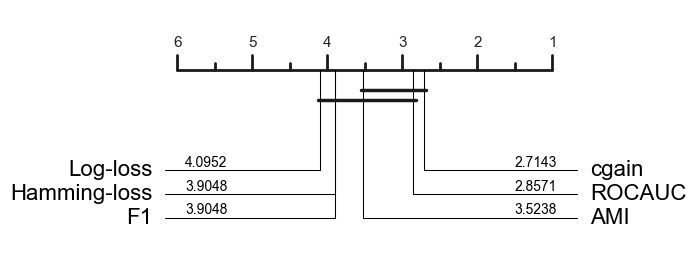

In [10]:
ax = plot_critical_difference(
    scores=df_scores.iloc[:, 1:].to_numpy(),
    labels=df_scores.columns[1:].to_numpy(),
    alpha=0.05,
)

plt.savefig("../../figures/cd_ablation_study_merge_score_train.pdf", bbox_inches="tight")

Let's plot the MCM.

In [11]:
dir_path = "../../figures/"
file_name = "mcm_ablation_study_merge_score_train"

MCM.compare(
    output_dir=dir_path,
    used_statistic="Score",
    save_as_json=False,
    df_results=df_scores.iloc[:, 1:],
    pdf_savename=file_name,
    load_analysis=False,
    pvalue_correction="Holm",
    row_comparates=("cgain",),
    fig_size=(20, 5),
    font_size=18,
    precision=3
)
Image(filename=os.path.join(dir_path, file_name + ".pdf"))

Processing F1, Hamming-loss:   0%|          | 0/6 [00:00<?, ?it/s]   

ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

Let's compute wins/losses against cgain.

In [12]:
selection = "cgain"

for rival in df_scores.columns[1:]:
    if rival == selection: continue

    df_pair = df_scores[[selection, rival]]
    pair_ranks = df_pair.rank(1, method='min', ascending=False)

    wins = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 2)].shape[0]
    losses = pair_ranks[(pair_ranks[selection] == 2) & (pair_ranks[rival] == 1)].shape[0]
    ties = pair_ranks[(pair_ranks[selection] == 1) & (pair_ranks[rival] == 1)].shape[0]

    assert wins + losses + ties == pair_ranks.shape[0]

    print(f"{selection} vs {rival}: (wins/ties/losses): {wins}/{ties}/{losses}")

cgain vs F1: (wins/ties/losses): 11/7/3
cgain vs Log-loss: (wins/ties/losses): 12/7/2
cgain vs AMI: (wins/ties/losses): 10/7/4
cgain vs Hamming-loss: (wins/ties/losses): 11/7/3
cgain vs ROCAUC: (wins/ties/losses): 5/12/4


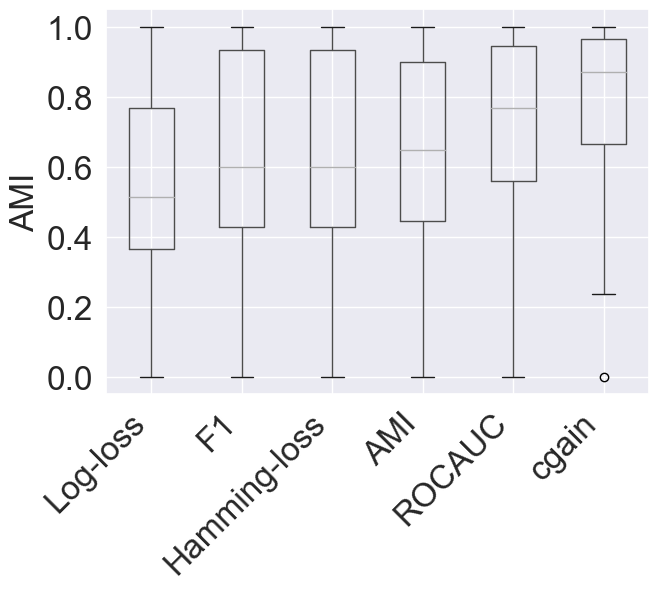

In [13]:
fontsize = 24
_, ax = plt.subplots(figsize=(7, 5))

# Sort by median performance
df_sorted_scores = df_scores[df_scores.iloc[:, 1:].median(axis=0).sort_values().index]

if eval_score == "covering_score":
    score_name = "Covering"
elif eval_score == "ami_score":
    score_name = "AMI"
else:
    assert False, "Unknown score."

df_sorted_scores.boxplot(ax=ax, rot=90)
ax.set_ylabel(score_name, fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)

ax.set_xticklabels(df_sorted_scores.columns, rotation=45, ha="right")
ax.set_yticks(np.round(np.arange(0, 1.0 + .2, .2), 1))

plt.savefig(f"../../figures/bp_ablation_study_merge_score_train.pdf", bbox_inches="tight")